In [33]:
import pickle
import tweepy
import re #https://developers.google.com/edu/python/regular-expressions
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import nltk
from nltk.collocations import *
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
#nltk.download('pos_tag')


import math

from PIL import Image


import community

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/LauJohansson/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [34]:
G = nx.read_gpickle("first_network_listversion.gpickle")

In [19]:
#G2 = nx.read_gpickle("second_network_w_weights_listversion.gpickle")

In [20]:
from nltk.corpus import stopwords
stopwords_danish = stopwords.words('danish')

# Community detection

Load all the tweets:

In [21]:
with open('tweet_dict_all.data', 'rb') as filehandle:
    tweet_dict_all = pickle.load(filehandle) 

In [22]:
G_directed=G

In [23]:
G_undirected=G.to_undirected()

In [24]:
Gcc = sorted(nx.weakly_connected_components(G_directed), key=len, reverse=True)
giant = G_undirected.subgraph(Gcc[0])

In [25]:
partition_GCC = community.best_partition(giant) #Giant connected component

In [26]:
#The number indicate the community
print('We found ',len(set(partition_GCC.values())),' communities in total.')

We found  9  communities in total.


# Concatenating all politicians tweets  for each politician

In [27]:
dict_concat=dict()

In [120]:
for pol in list(tweet_dict_all.keys()):
    dict_concat[pol]=' '.join(tweet_dict_all[pol])
    #dict_concat[pol] = re.sub(r'^https?:\/\/.*[\r\n]*', '', dict_concat[pol], flags=re.MULTILINE)
    dict_concat[pol] = re.sub(r"http\S+", "", dict_concat[pol]) #remove links
    

In [38]:
with open('tweet_concat.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(dict_concat, filehandle)

In [135]:
from wordcloud import WordCloud, STOPWORDS

In [136]:
STOPWORDS=STOPWORDS.union(stopwords_danish)
STOPWORDS=STOPWORDS.union(["rt"])# RT is some twitter syntax 

In [137]:
largest_communities=list(set(partition_GCC.values()))

In [142]:
import lemmy #Danish Lematizer
lemmatizer = lemmy.load("da")

## POS? START

In [56]:
#pip install stanfordnlp

In [57]:
#import stanfordnlp

In [58]:
#nltk.pos_tag(["løbe"])

In [59]:
#nlp = stanfordnlp.Pipeline(lang='en')

## POS? end

In [150]:
community_text =  dict()
TF_dc = dict()


for i in range(len(largest_communities)):

   
    common_characters = [k for k,v in list(partition_GCC.items()) if v == largest_communities[i]]

    # reset collection of words for each community
    dc_words=[]

    # Tokenize the text in all files in community i and concatenate into one text
    for pol in list(dict_concat.keys()):
            if pol in common_characters:
              
                dc_words += nltk.word_tokenize(dict_concat[pol])
    
    # enter all text from community i in a dict
    dc_tokens = [word.lower() for word in dc_words if (word.isalnum() and word.lower() not in STOPWORDS)]
    words_lemmatized=[lemmatizer.lemmatize("",t)[0] for t in dc_tokens]
    
    community_text[largest_communities[i]] = words_lemmatized

for i in community_text.keys():
    TF_dc[i] = FreqDist(community_text[i])

In [151]:
# number of words and text
common_communities=largest_communities
for i in range(len(common_communities)):
    print('Community ', common_communities[i],' has ', len(community_text[common_communities[i]]), ' words')

Community  0  has  131266  words
Community  1  has  216759  words
Community  2  has  194526  words
Community  3  has  187300  words
Community  4  has  71955  words
Community  5  has  109585  words
Community  6  has  66225  words


In [152]:
#inverse document frequency
def IDF_for_word(word, this_com_name, TF_other_community, N):
 
    nt=0
 
    for com in list(TF_other_community.keys()):
        if word in TF_other_community[com] and com != this_com_name:
            nt = nt+1
 
    w_IDF=np.log(N/(nt+1))+1
    return w_IDF

In [153]:
IDF = dict()

for community in TF_dc.keys():
    IDF.update({community: {}})
    for word in TF_dc[community].keys():
        IDF[community].update({word: IDF_for_word(word, community, TF_dc, 7)})

In [154]:
TF_IDF = dict()

for community in TF_dc.keys():
    TF_IDF.update({community: {}})
    for word in TF_dc[community].keys():
        TF_IDF[community].update({word: TF_dc[community][word]*IDF[community][word]})

In [155]:
twitter_mask=np.array(Image.open('twitter_sil.jpg'))

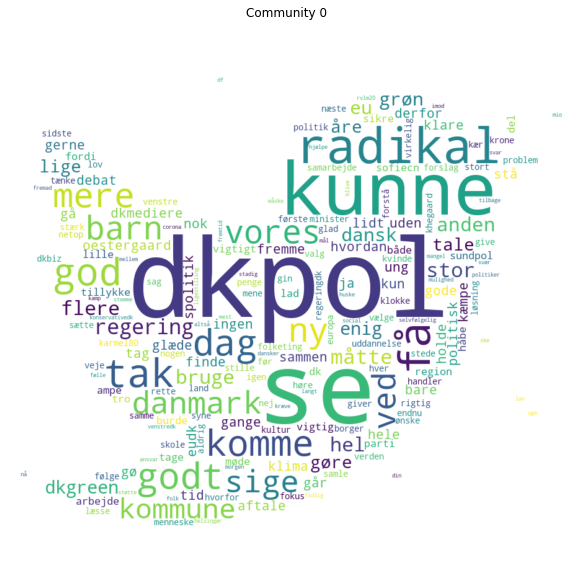

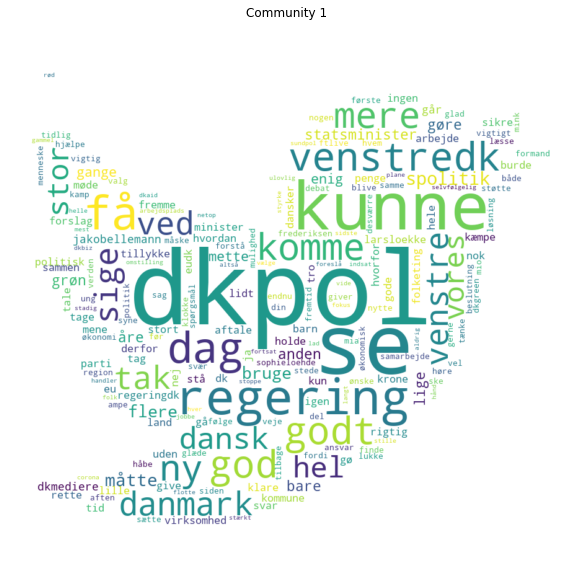

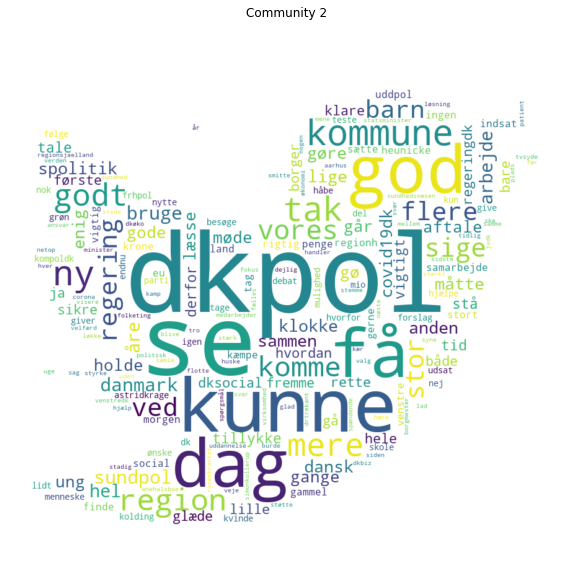

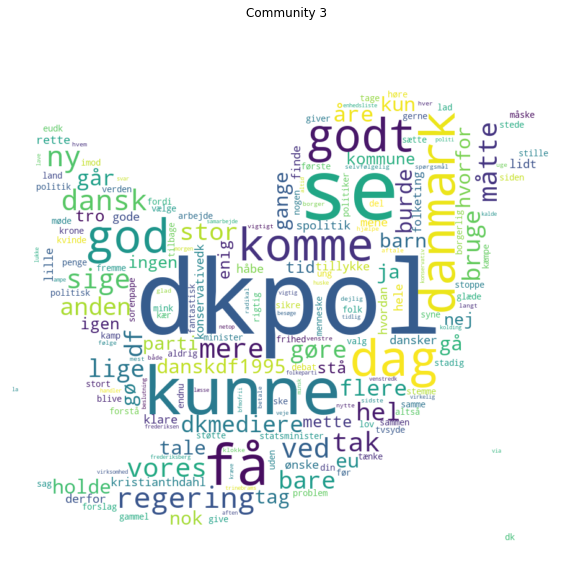

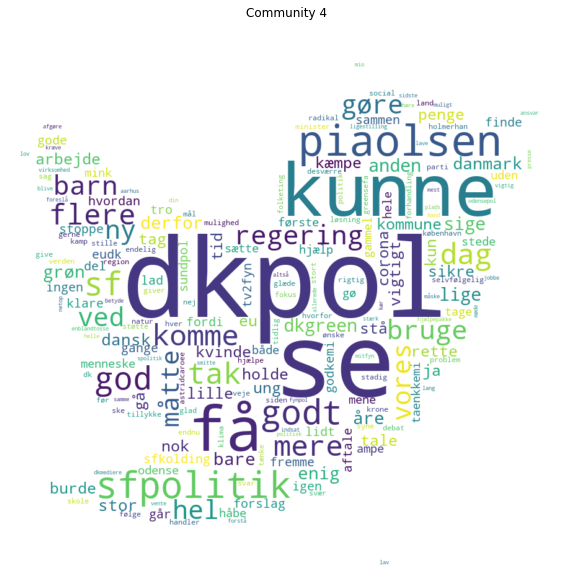

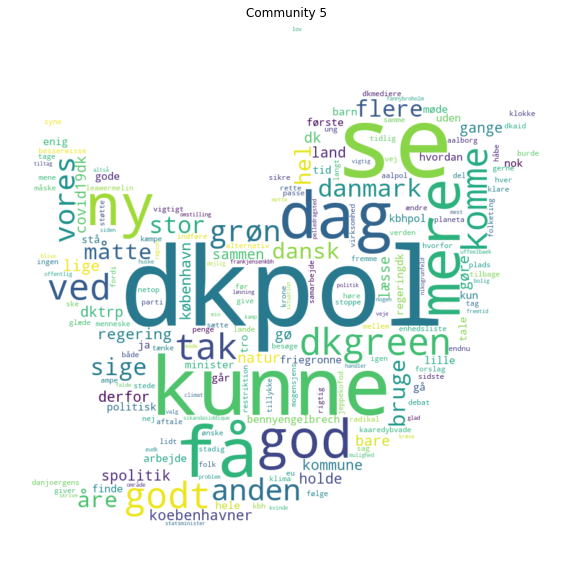

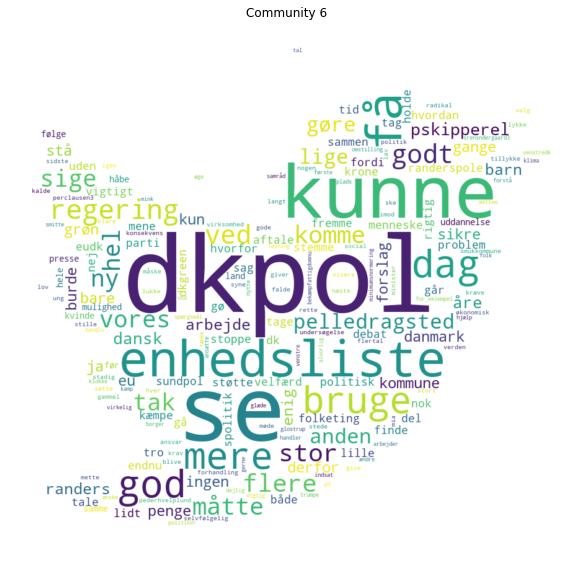

In [156]:
for community in TF_IDF.keys():
    community_WordCloudText = ' '.join([word for word in list(TF_IDF[community].keys()) for i in range(math.ceil(TF_IDF[community][word]))])

    plt.figure(figsize=(10,20))
    community_wordcloud = WordCloud(collocations=False, mask=twitter_mask, background_color='white').generate(community_WordCloudText)
    plt.imshow(community_wordcloud, interpolation='bilinear')
    plt.title(label=('Community '+str(community)))
    plt.axis("off")

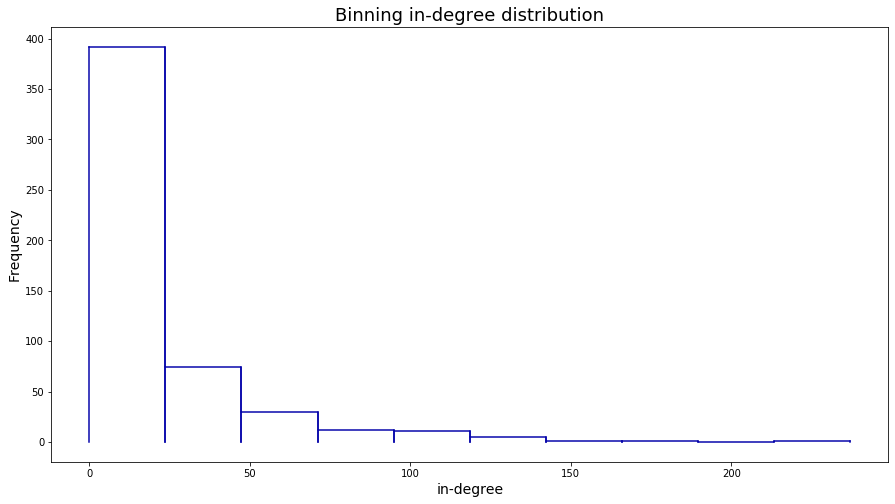

In [24]:
hist,bin_edges=np.histogram(list_in,bins=10)

rightboundary=bin_edges[1:]
leftboundary=bin_edges[:-1]
newlist_in=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
newvalues_in=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
for i in range(len(rightboundary)):
    newlist_in.append(leftboundary[i])
    newvalues_in.append(hist[i])
    newlist_in.append(rightboundary[i])
    newvalues_in.append(hist[i]) 
points_in=zip(newlist_in,newvalues_in)
 
plt.figure(figsize=(15,8))
plt.plot(newlist_in,newvalues_in,color='#0504aa')
for pt in points_in:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )
 
plt.title('Binning in-degree distribution',fontsize=18)
plt.xlabel("in-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
#plt.axis([0, 140, 0, 500])
plt.show()

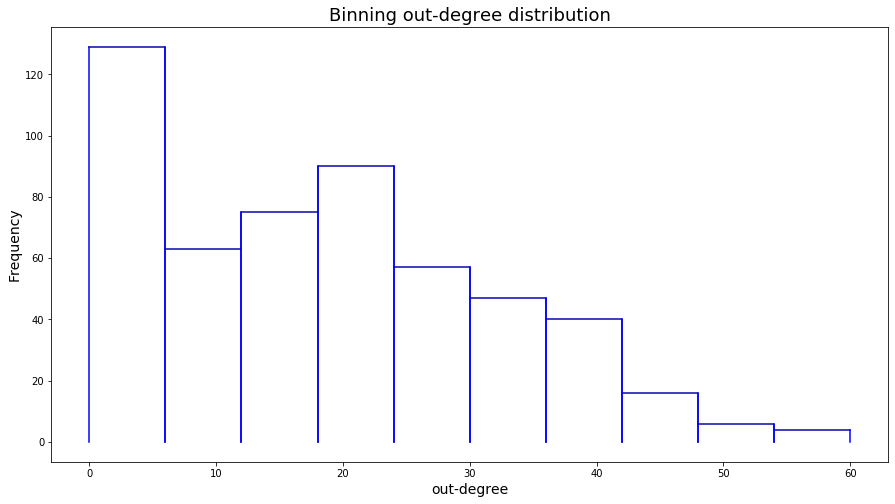

In [25]:
hist,bin_edges=np.histogram(list_out,bins=10)

rightboundary=bin_edges[1:]
leftboundary=bin_edges[:-1]
newlist_out=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
newvalues_out=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
for i in range(len(rightboundary)):
    newlist_out.append(leftboundary[i])
    newvalues_out.append(hist[i])
    newlist_out.append(rightboundary[i])
    newvalues_out.append(hist[i]) 
points_out=zip(newlist_out,newvalues_out)
 
plt.figure(figsize=(15,8))
plt.plot(newlist_out,newvalues_out,color='#0504aa')
for pt in points_out:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="blue" )
 
plt.title('Binning out-degree distribution',fontsize=18)
plt.xlabel("out-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
#plt.axis([0, 140, 0, 200])
plt.show()

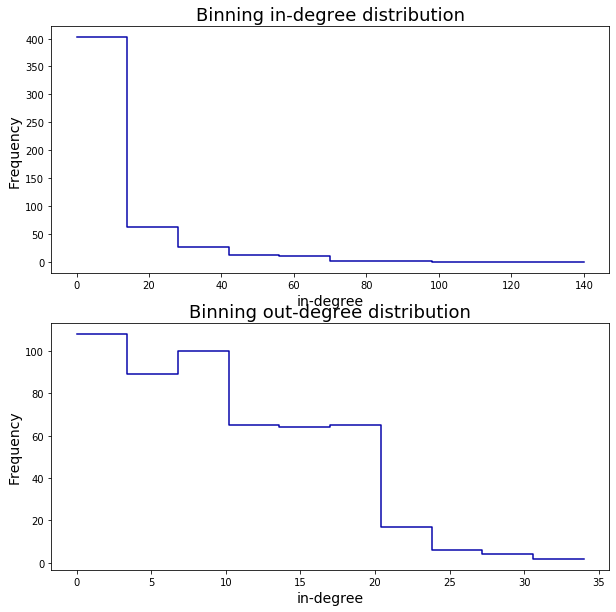

In [126]:

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,figsize=(10,10))

##FIRST PLOT
ax1 = plt.subplot(211)
plt.plot(newlist_in,newvalues_in,color='#0504aa')
for pt in points_in:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )
plt.title('Binning in-degree distribution',fontsize=18)
plt.xlabel("in-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)

#SECOND PLOT
ax2 = plt.subplot(212)
plt.plot(newlist_out,newvalues_out,color='#0504aa')
for pt in points_out:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="blue" )
plt.title('Binning out-degree distribution',fontsize=18)
plt.xlabel("in-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)

# some code to share both x axis


plt.show()

# Force atlas

In [26]:
G2_undirected=G2.to_undirected()

In [27]:
Gcc = sorted(nx.weakly_connected_components(G2), key=len, reverse=True)
giant_directed=G2.subgraph(Gcc[0])
giant = G2_undirected.subgraph(Gcc[0])

In [28]:
from fa2 import ForceAtlas2

In [29]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:11<00:00, 166.78it/s]

BarnesHut Approximation  took  2.67  seconds
Repulsion forces  took  8.20  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.28  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


In [30]:
d = dict(giant.degree)

/Users/LauJohansson/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


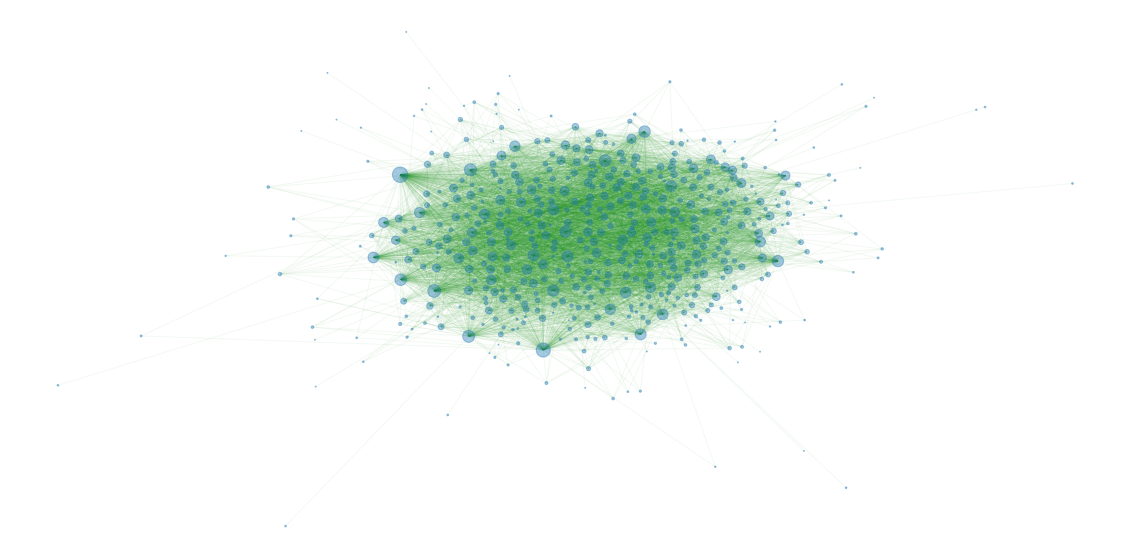

In [31]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, alpha=0.4,node_size=[v * 1 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

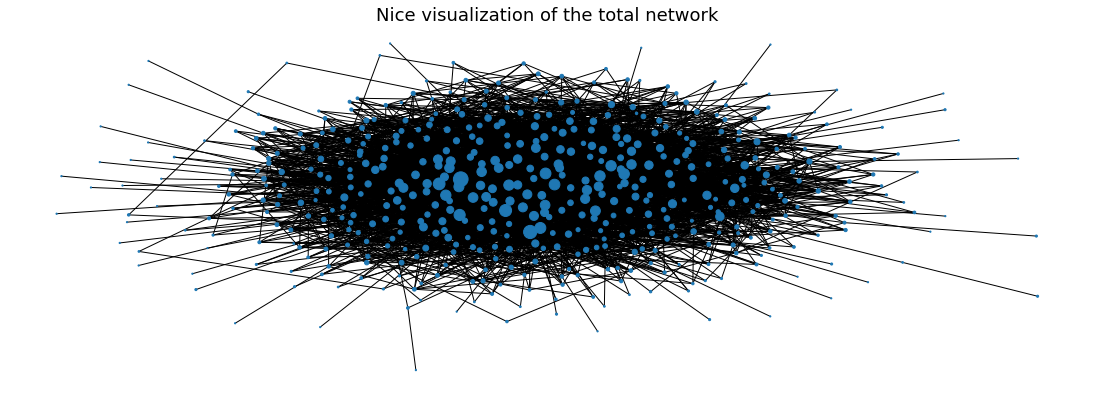

In [154]:
plt.figure(figsize=(15,5))
nx.draw_kamada_kawai(giant, node_size=[v * 1.5 for v in d.values()], width=1)

plt.title("Nice visualization of the total network",fontsize=18)
plt.show()

# Analysis on giant

In [163]:
giant_directed.number_of_nodes()

513

In [164]:
giant_directed.number_of_edges()

5085

In [165]:
list_in=list(dict(giant_directed.in_degree()).values()) # This is all of the nodes' degrees
list_out=list(dict(giant_directed.out_degree()).values()) # This is all of the nodes' degrees

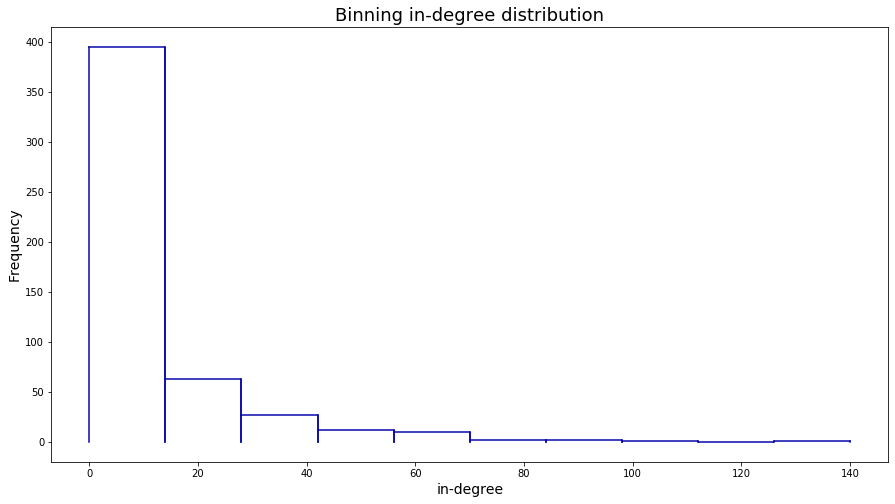

In [166]:
hist,bin_edges=np.histogram(list_in,bins=10)

rightboundary=bin_edges[1:]
leftboundary=bin_edges[:-1]
newlist_in=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
newvalues_in=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
for i in range(len(rightboundary)):
    newlist_in.append(leftboundary[i])
    newvalues_in.append(hist[i])
    newlist_in.append(rightboundary[i])
    newvalues_in.append(hist[i]) 
points_in=zip(newlist_in,newvalues_in)
 
plt.figure(figsize=(15,8))
plt.plot(newlist_in,newvalues_in,color='#0504aa')
for pt in points_in:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )
 
plt.title('Binning in-degree distribution',fontsize=18)
plt.xlabel("in-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
#plt.axis([0, 140, 0, 500])
plt.show()

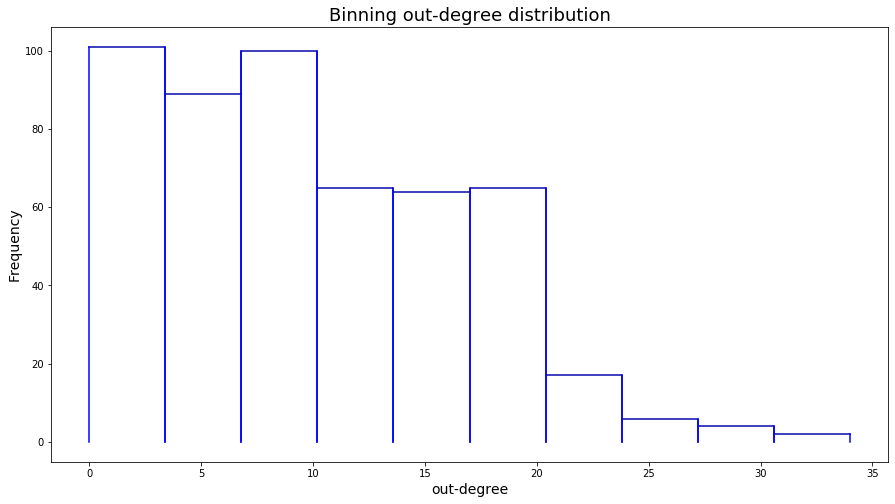

In [167]:
hist,bin_edges=np.histogram(list_out,bins=10)

rightboundary=bin_edges[1:]
leftboundary=bin_edges[:-1]
newlist_out=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
newvalues_out=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
for i in range(len(rightboundary)):
    newlist_out.append(leftboundary[i])
    newvalues_out.append(hist[i])
    newlist_out.append(rightboundary[i])
    newvalues_out.append(hist[i]) 
points_out=zip(newlist_out,newvalues_out)
 
plt.figure(figsize=(15,8))
plt.plot(newlist_out,newvalues_out,color='#0504aa')
for pt in points_out:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="blue" )
 
plt.title('Binning out-degree distribution',fontsize=18)
plt.xlabel("out-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
#plt.axis([0, 140, 0, 200])
plt.show()

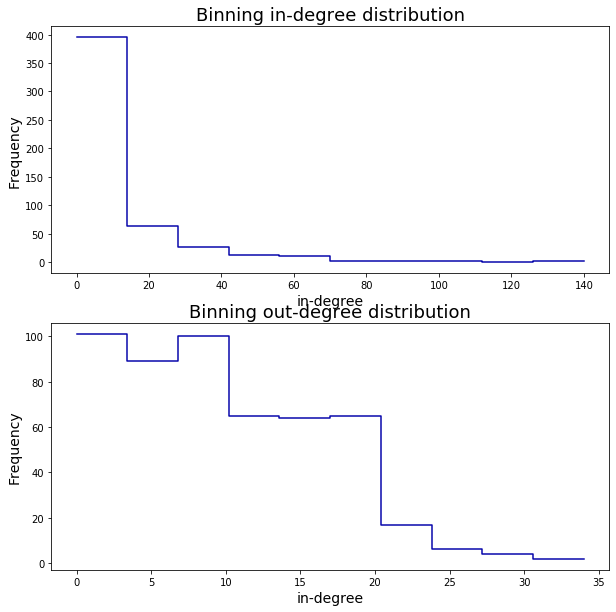

In [168]:

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,figsize=(10,10))

##FIRST PLOT
ax1 = plt.subplot(211)
plt.plot(newlist_in,newvalues_in,color='#0504aa')
for pt in points_in:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )
plt.title('Binning in-degree distribution',fontsize=18)
plt.xlabel("in-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)

#SECOND PLOT
ax2 = plt.subplot(212)
plt.plot(newlist_out,newvalues_out,color='#0504aa')
for pt in points_out:
    plt.plot( [pt[0],pt[0]], [0,pt[1]],color="blue" )
plt.title('Binning out-degree distribution',fontsize=18)
plt.xlabel("in-degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)

# some code to share both x axis


plt.show()

In [176]:
pd_tweet_dict.count().sum()

5092

# To do / considerations

* Some posts do not tag other politicians, but just mention them in plain text. These kinds of non-tags of other persons have we not accounted for. They should possible be taken into account. (E.g. Kristian Thulesen Dahl write: "(...) Mette Frederiksen (...)" without a @. 

* Find out how to include re-tweet

* OBS: THe danish prime minister, Mette Frederiksen, does not have a twitter account.

* Should we include the parties own official twitter-profile as a "person"

* Make regex/"for name in" on all names (not just @) and all parties
